# 0. Установка зависимостей, импортирование данных

In [25]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [27]:
df = pd.read_csv(os.path.join('data','train.csv'))

In [28]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Препроцессинг данных

In [30]:
from tensorflow.keras.layers import TextVectorization

In [31]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [32]:
MAX_FEATURES = 200000 # number of words in the vocab

In [44]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=500,
                               output_mode='int')

In [45]:
vectorizer.adapt(X.values)

In [46]:
vectorized_text = vectorizer(X.values)

In [47]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [48]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Создание модели

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [40]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [41]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [49]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 590s 84ms/step - loss: 0.0597 - val_loss: 0.0461
Epoch 2/10
6981/6981 [==============================] - 589s 84ms/step - loss: 0.0456 - val_loss: 0.0404
Epoch 3/10
6981/6981 [==============================] - 591s 85ms/step - loss: 0.0410 - val_loss: 0.0348
Epoch 4/10
6981/6981 [==============================] - 593s 85ms/step - loss: 0.0364 - val_loss: 0.0316
Epoch 5/10
6981/6981 [==============================] - 588s 84ms/step - loss: 0.0318 - val_loss: 0.0300
Epoch 6/10
6981/6981 [==============================] - 585s 84ms/step - loss: 0.0290 - val_loss: 0.0258
Epoch 7/10
6981/6981 [==============================] - 586s 84ms/step - loss: 0.0261 - val_loss: 0.0217
Epoch 8/10
6981/6981 [==============================] - 587s 84ms/step - loss: 0.0234 - val_loss: 0.0198
Epoch 9/10
6981/6981 [==============================] - 591s 85ms/step - loss: 0.0213 - val_loss: 0.0184
Epoch 10/10
6981/6981 [==============================] 

In [50]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

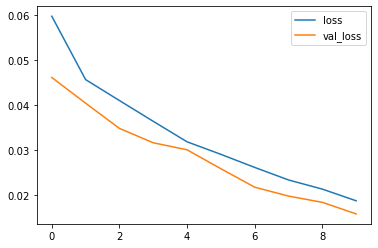

In [51]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Проверка предсказания

In [52]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [56]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 35ms/step


In [57]:
(res > 0.5).astype(int)

#toxic severe_toxic obscene threat insult identity_hate

array([[1, 1, 1, 0, 1, 0]])

In [58]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [59]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 55ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [60]:
res.shape

(1, 6)

# 4. Оценка модели

In [61]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [62]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [63]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 59ms/step


In [64]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9288560152053833, Recall:0.9220339059829712, Accuracy:0.5115346312522888


# 5. Сохранение модели

In [65]:
import tensorflow as tf
import gradio as gr

In [66]:
model.save('toxicity.h5')

In [67]:
model = tf.keras.models.load_model('toxicity.h5')

In [68]:
input_str = vectorizer('hey i freaken hate you!')

In [69]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 749ms/step


In [70]:
res

array([[0.859469  , 0.00519064, 0.02414891, 0.00937987, 0.50757086,
        0.05970578]], dtype=float32)